<a href="https://colab.research.google.com/github/RahulBattula/bharat_intenship/blob/main/Bird-Audio-Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN architecture for classifying sounds
Convolutional Neural Networks are most commonly used to classify images. However, through data processing sounds can be interpreted as images and be used as such in ML algorithms. This notebook provides an example of this technique on a dataset of common American bird calls.

#### Importing required libraries:

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
from glob import glob
import IPython.display as ipd
import tensorflow as tf
from PIL import Image

This is the dataset we are working with. Most of the data can be discarded, as we only need bird's name and the recording of it's call.

In [23]:
df = pd.read_csv("/content/bird_songs_metadata.csv")
df.head(3)

,id,genus,species,subspecies,name,recordist,country,location,latitude,longitude,altitude,sound_type,source_url,license,time,date,remarks,filename
0,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-0.wav
1,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-1.wav
2,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-4.wav


In [24]:
class_names = df["name"].unique()
class_names

array(["Bewick's Wren", 'Northern Mockingbird', 'American Robin',
       'Song Sparrow', 'Northern Cardinal'], dtype=object)

In [25]:
df["name"].value_counts()

Song Sparrow            1256
Northern Mockingbird    1182
Northern Cardinal       1074
American Robin          1017
Bewick's Wren            893
Name: name, dtype: int64

How many samples for each bird are represented in the dataset.

<BarContainer object of 5 artists>

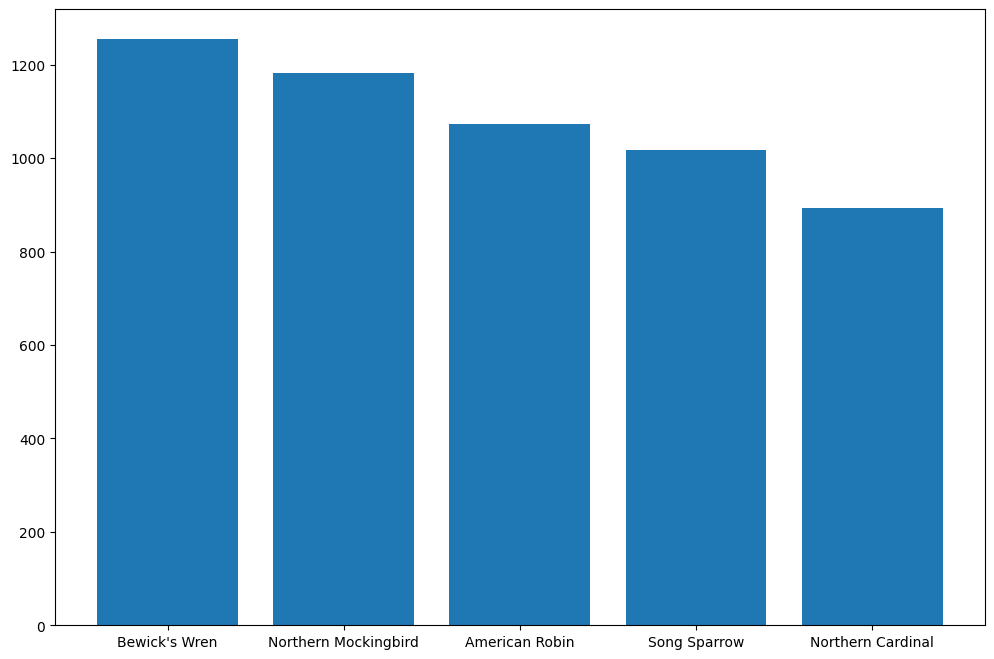

In [26]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.bar(df["name"].unique(), df["name"].value_counts())

### Mel Spectrogram

Spectrogram is created by sliding a "window" through the data and applying the Fourier transform, splitting the signal into several composing signals and their individual amplitudes. In a spectrogram, X-axis is time, Y-axis is frequency in hertz, and color is loudness. However, humans do not perceive sound on a linear scale, as we can tell the difference between someone whispering (quiet sound) and someone shouting (loud sound) easily, but we have a hard time differentiating between different loud sounds, such as a rocket or a plane taking off. A mel spectrogram represents frequencies on a logarithmic scale.
Since a spectrogram can be represented by an image, the same CNN architecture for classifying images can be used to classify sounds./kaggle/input/bird-song-data-set/wavfiles

In [27]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"rahulbattula1","key":"2aeae7ca26b1e15437195539926c7b01"}'}

In [28]:
!cp kaggle.json ~/.kaggle/

In [29]:
! kaggle datasets list

ref                                                                 title                                             size  lastUpdated          downloadCount  voteCount  usabilityRating  
------------------------------------------------------------------  -----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
thedrcat/daigt-v2-train-dataset                                     DAIGT V2 Train Dataset                            29MB  2023-11-16 01:38:36           1806        180  1.0              
thedevastator/books-sales-and-ratings                               Books Sales and Ratings                           53KB  2023-12-06 04:54:33           1722         28  1.0              
muhammadbinimran/housing-price-prediction-data                      Housing Price Prediction Data                    763KB  2023-11-21 17:56:32           8112        146  1.0              
jocelyndumlao/cardiovascular-disease-dataset           

In [30]:
!kaggle datasets download -d vinayshanbhag/bird-song-data-set

100% 2.09G/2.09G [00:20<00:00, 134MB/s]
100% 2.09G/2.09G [00:20<00:00, 107MB/s]


In [31]:
!unzip bird-song-data-set.zip

Streaming output truncated to the last 5000 lines.
  inflating: wavfiles/321906-11.wav  
  inflating: wavfiles/321906-12.wav  
  inflating: wavfiles/321906-13.wav  
  inflating: wavfiles/321906-2.wav   
  inflating: wavfiles/321906-3.wav   
  inflating: wavfiles/321906-4.wav   
  inflating: wavfiles/321906-5.wav   
  inflating: wavfiles/321906-6.wav   
  inflating: wavfiles/321906-7.wav   
  inflating: wavfiles/321906-8.wav   
  inflating: wavfiles/321906-9.wav   
  inflating: wavfiles/321913-0.wav   
  inflating: wavfiles/321913-1.wav   
  inflating: wavfiles/321913-10.wav  
  inflating: wavfiles/321913-11.wav  
  inflating: wavfiles/321913-12.wav  
  inflating: wavfiles/321913-13.wav  
  inflating: wavfiles/321913-2.wav   
  inflating: wavfiles/321913-3.wav   
  inflating: wavfiles/321913-4.wav   
  inflating: wavfiles/321913-5.wav   
  inflating: wavfiles/321913-8.wav   
  inflating: wavfiles/321913-9.wav   
  inflating: wavfiles/321914-0.wav   
  inflating: wavfiles/321914-1.wav   

In [32]:
path_to_wav = "/content/wavfiles/"
datafiles = glob(path_to_wav + "*")

In [33]:
def create_mel_spectogram(audio_file, name):
    y, sr = librosa.load(path_to_wav + audio_file)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr)
    mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

    fig, ax = plt.subplots(figsize=(15, 5))

    ax.set_title("Mel Spec")
    plt.suptitle(name)
    librosa.display.specshow(mel_spec, x_axis='time', y_axis='log', ax=ax)
    return ipd.Audio(path_to_wav + audio_file, rate=sr)

See examples of audiosamples and spectrograms:

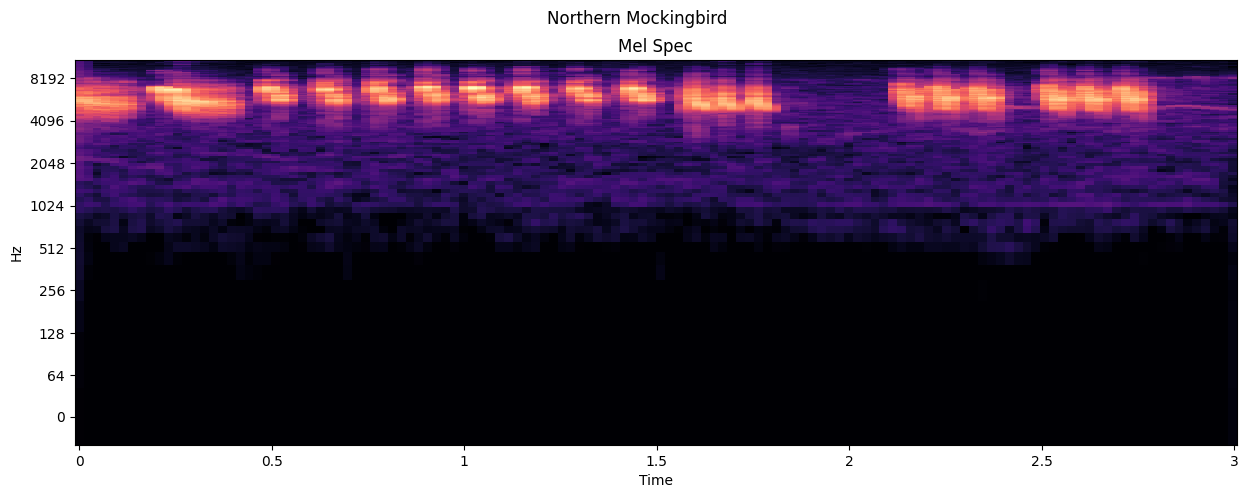

In [34]:
i = np.random.randint(0, df.shape[0])
create_mel_spectogram(df.loc[i, "filename"], df.loc[i, "name"])

In [35]:
def process_audio(audio_file):
    y, sr = librosa.load(audio_file, duration=10)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr)
    mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec

Creating a new dataframe containing only the columns we need.

In [36]:
df_train = pd.DataFrame({"name":df.loc[:, "name"], "audiopath": path_to_wav + df.loc[:, "filename"]})
df_train["mel_spec"] = df_train["audiopath"].apply(process_audio)
df_train["class"] = df_train["name"].factorize()[0]

In [37]:
from sklearn.utils import shuffle

df_train = shuffle(df_train)
df_train.shape

(5422, 4)

Splitting training and testing datasets. Test dataset will also be used as validation set.

In [38]:
(train_x, train_y) = df_train["mel_spec"][:5000].values, df_train["class"][:5000].values
(test_x, test_y) = df_train["mel_spec"][5000:].values, df_train["class"][5000:].values

One-hot encoding class names.

In [39]:
from keras.utils import to_categorical

test_y = to_categorical(test_y, num_classes=5)
train_y = to_categorical(train_y, num_classes=5)

In [40]:
train_x = np.stack(train_x[:])
test_x = np.stack(test_x[:])

train_x = tf.keras.utils.normalize(train_x)
test_x = tf.keras.utils.normalize(test_x)

train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y))
test_dataset = tf.data.Dataset.from_tensor_slices((test_x, test_y))

In [41]:
train_dataset = train_dataset.batch(8)
test_dataset = test_dataset.batch(8)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

In [42]:
import keras
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization, Reshape, InputLayer, TimeDistributed, Conv1D, MaxPooling1D, LSTM
from keras.models import Sequential
from keras.regularizers import l2

Batch normalization, ridge regression (L2) and drop-out layers are used to minimise overfitting.

In [43]:
def create_model():
    model = keras.models.Sequential(name="model")

    model.add(InputLayer(input_shape=(128,130)))
    model.add(Reshape((128, 130, 1)))
    model.add(Conv2D(64, (8, 8), input_shape=(128, 130),activation='relu', padding='same'))
    model.add(Conv2D(64, (6, 6), activation='relu', padding='same'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (5, 5),activation='relu',padding='same'))
    model.add(Conv2D(128, (5, 5),activation='relu',padding='same'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(256, (3, 3),activation='relu',padding='same'))
    model.add(Conv2D(256, (3, 3),activation='relu',padding='same'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(5))
    model.add(Activation('softmax'))

    return model


In [44]:
model = create_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 128, 130, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 130, 64)      4160      
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 130, 64)      147520    
                                                                 
 dropout (Dropout)           (None, 128, 130, 64)      0         
                                                                 
 batch_normalization (Batch  (None, 128, 130, 64)      256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 65, 64)        0         
 D)                                                          

In [45]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("model.h5", save_best_only=True)

from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy

model.compile(loss=CategoricalCrossentropy(), optimizer=Adam(learning_rate=0.01), metrics=['accuracy'])

In [51]:
model.fit(train_dataset, epochs=50, validation_data=test_dataset, callbacks=[checkpoint_cb])

Epoch 1/50
625/625 [==============================] - 42s 68ms/step - loss: 1.7162 - accuracy: 0.7086 - val_loss: 1.7944 - val_accuracy: 0.6540
Epoch 2/50
625/625 [==============================] - 43s 69ms/step - loss: 1.8315 - accuracy: 0.7206 - val_loss: 1.6984 - val_accuracy: 0.6754
Epoch 3/50
625/625 [==============================] - 43s 69ms/step - loss: 1.7803 - accuracy: 0.7372 - val_loss: 2.1045 - val_accuracy: 0.6564
Epoch 4/50
625/625 [==============================] - 43s 69ms/step - loss: 1.6995 - accuracy: 0.7454 - val_loss: 1.7335 - val_accuracy: 0.6991
Epoch 5/50
625/625 [==============================] - 43s 69ms/step - loss: 1.6430 - accuracy: 0.7454 - val_loss: 2.1288 - val_accuracy: 0.6469
Epoch 6/50
625/625 [==============================] - 43s 69ms/step - loss: 1.7218 - accuracy: 0.7620 - val_loss: 1.7291 - val_accuracy: 0.6919
Epoch 7/50
625/625 [==============================] - 43s 68ms/step - loss: 1.6821 - accuracy: 0.7754 - val_loss: 1.7366 - val_accuracy:

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 43s 69ms/step - loss: 1.6273 - accuracy: 0.8214 - val_loss: 1.5963 - val_accuracy: 0.8033
Epoch 12/50
625/625 [==============================] - 43s 68ms/step - loss: 1.5473 - accuracy: 0.8242 - val_loss: 2.0748 - val_accuracy: 0.6611
Epoch 13/50
625/625 [==============================] - 43s 69ms/step - loss: 1.4700 - accuracy: 0.8324 - val_loss: 1.1930 - val_accuracy: 0.8436
Epoch 14/50
625/625 [==============================] - 43s 69ms/step - loss: 1.4696 - accuracy: 0.8334 - val_loss: 1.5946 - val_accuracy: 0.7630
Epoch 15/50
625/625 [==============================] - 43s 69ms/step - loss: 1.4443 - accuracy: 0.8472 - val_loss: 2.0644 - val_accuracy: 0.6919
Epoch 16/50
625/625 [==============================] - 43s 68ms/step - loss: 1.4466 - accuracy: 0.8554 - val_loss: 2.0632 - val_accuracy: 0.6445
Epoch 17/50
625/625 [==============================] - 43s 68ms/step - loss: 1.4763 - accuracy: 0.8522 - val_loss: 1.5314 - val_accuracy: 0.76

Pre-trained weights are included in the folder. Training without GPU is simply not feasible, but you can test model's performance without training it./kaggle/input/models

In [52]:
# model.load_weights("/kaggle/input/models/model.h5")

#### Evaluating performance

In [53]:
model.evaluate(test_dataset)

53/53 [==============================] - 1s 17ms/step - loss: 1.3253 - accuracy: 0.8341


[1.3252795934677124, 0.8341231942176819]

In [54]:
pred_y = model.predict(test_x).argmax(axis=1, keepdims=True)
true_y = test_y.argmax(axis=1, keepdims=True)

14/14 [==============================] - 0s 35ms/step


##### Plotting confusion matrix.
Overall, model is performing pretty well with accuracy of 94% (using the pre-trained weights included in the files). Confusion matrix shows False Positives and False Negativese for each class.

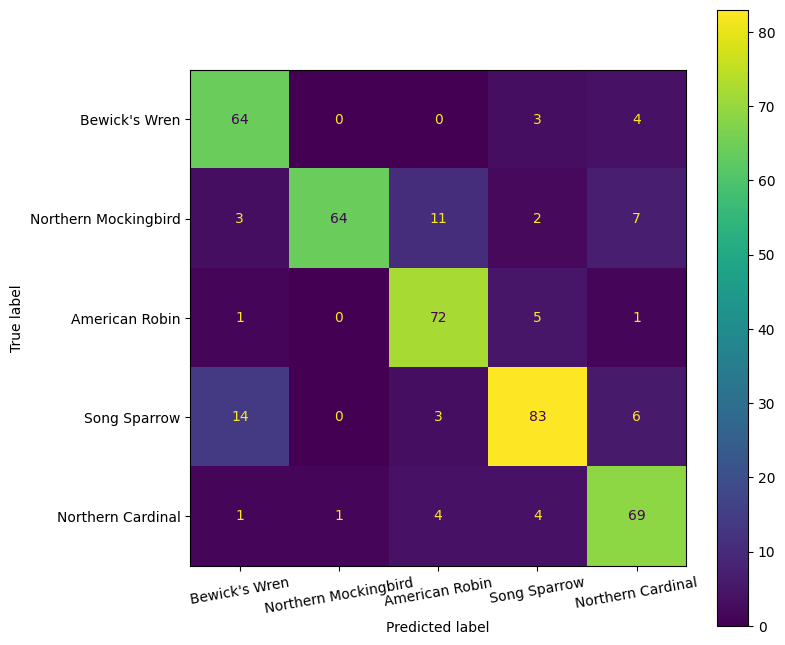

In [55]:
import sklearn.metrics

confusion_matrix = sklearn.metrics.confusion_matrix(true_y, pred_y)
confusion_matrix_display = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix, display_labels=class_names)
fig, ax = plt.subplots(1, figsize=(8, 8))
confusion_matrix_display.plot(ax=ax, xticks_rotation=10)

In [59]:
# Access the training history from the model
history = model.fit(train_dataset, epochs=50, validation_data=test_dataset, callbacks=[checkpoint_cb])
model_history = model.history

# Extract loss values
train_loss = model_history.history["loss"]
val_loss = model_history.history["val_loss"]

# Plot the loss curves
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(train_loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve")
plt.show()


Epoch 1/50
 85/625 [===>..........................] - ETA: 34s - loss: 1.0564 - accuracy: 0.9500

KeyboardInterrupt: ignored